Divya Gupta
Indian Statistical Institute Chennai

# Real Estate Price Prediction Analysis                                                                            
                                                                                                    

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn import metrics

In [7]:
def mape(test,train,y_pred,y_pred_train):
    test['predicted_price'] = y_pred
    train['predicted_price'] = y_pred_train

    def percent_dev(one_pr, demand_pr):
        return abs(demand_pr - one_pr)*100/one_pr
    def percent_dev_sign(one_pr, demand_pr):
        return (demand_pr - one_pr)*100/one_pr

    train["MAPe"] = train[["price","predicted_price"]].apply(lambda x: percent_dev(one_pr=x["price"], demand_pr=x["predicted_price"]), axis=1)
    train["MPe"] = train[["price","predicted_price"]].apply(lambda x: percent_dev_sign(one_pr=x["price"], demand_pr=x["predicted_price"]), axis=1)
    test["MAPe"] = test[["price","predicted_price"]].apply(lambda x: percent_dev(one_pr=x["price"], demand_pr=x["predicted_price"]), axis=1)
    test["MPe"] = test[["price","predicted_price"]].apply(lambda x: percent_dev_sign(one_pr=x["price"], demand_pr=x["predicted_price"]), axis=1)
    
    train_Mape = np.round((len(train[train['MAPe']<=20])/len(train))*100)
    test_Mape = np.round((len(test[test['MAPe']<=20])/len(test))*100)
    
#     print('train_mape_within_20%',train_Mape),\
#     # print('train_mpe',len(train[train['MPe']<=20])/len(train)*100),\
#     print('test_mape_within_20%',test_Mape),\
#     # print('test_mpe',len(test[test['MPe']<=20])/len(test)*100)
    return train_Mape,test_Mape

def model_results(model,X_test_scaled,test,X_train_scaled, train):
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(test['price'], y_pred)
#     print("Mean Squared Error:", mse)

    y_pred_train = model.predict(X_train_scaled)
    mse = mean_squared_error(train['price'], y_pred_train)
#     print("Mean Squared Error:", mse)

    test['predicted_price'] = y_pred
    train['predicted_price'] = y_pred_train

    train_Mape,test_Mape = mape(test,train,y_pred,y_pred_train)
    Train_R2_Score = metrics.explained_variance_score(train['price'], y_pred_train)
    Test_R2_Score = metrics.explained_variance_score(test['price'], y_pred)

    results = pd.DataFrame({'DataSet':['Train','Test'], 'Size':[train.shape[0], test.shape[0]], 'MAPE_%':[train_Mape,test_Mape],\
                 'R2_Score_%':[np.round(Train_R2_Score*100),np.round(Test_R2_Score*100)]})
    return results

def lower_upper(data,col): 
    percentile25 = data[col].quantile(0.25) 
    percentile75 = data[col].quantile(0.75) 
    iqr = percentile75 - percentile25 
    upper_limit = percentile75 + 1.5 * iqr 
    lower_limit = percentile25 - 1.5 * iqr 
    return upper_limit,lower_limit

In [8]:
df = pd.read_excel('realestate.xlsx')

In [9]:
df.columns

Index(['PRICE ($)', 'SQFT', 'BED', 'BATH', 'FLOORS', 'DIST (km)'], dtype='object')

In [10]:
df = df.rename(columns = {'DIST (km)':'km','PRICE ($)':'price'})

In [11]:
df.describe()

,price,SQFT,BED,BATH,FLOORS,km
count,5.740000e+02,574.000000,574.000000,574.000000,574.000000,574.000000
mean,7.097687e+05,1158.621951,1.423345,1.426829,7.726481,1.581291
std,4.293103e+05,560.896520,0.786144,0.582507,4.484617,0.945423
min,1.300000e+05,270.000000,0.000000,1.000000,3.000000,0.030000
25%,4.000000e+05,736.500000,1.000000,1.000000,4.000000,0.739500
50%,6.075000e+05,988.500000,1.000000,1.000000,5.000000,1.713500
75%,9.050000e+05,1467.750000,2.000000,2.000000,11.750000,2.439000
max,2.975000e+06,3139.000000,3.000000,3.000000,16.000000,3.171000


# Bivariant Analysis

C:\Users\RISHI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\RISHI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\RISHI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\RISHI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

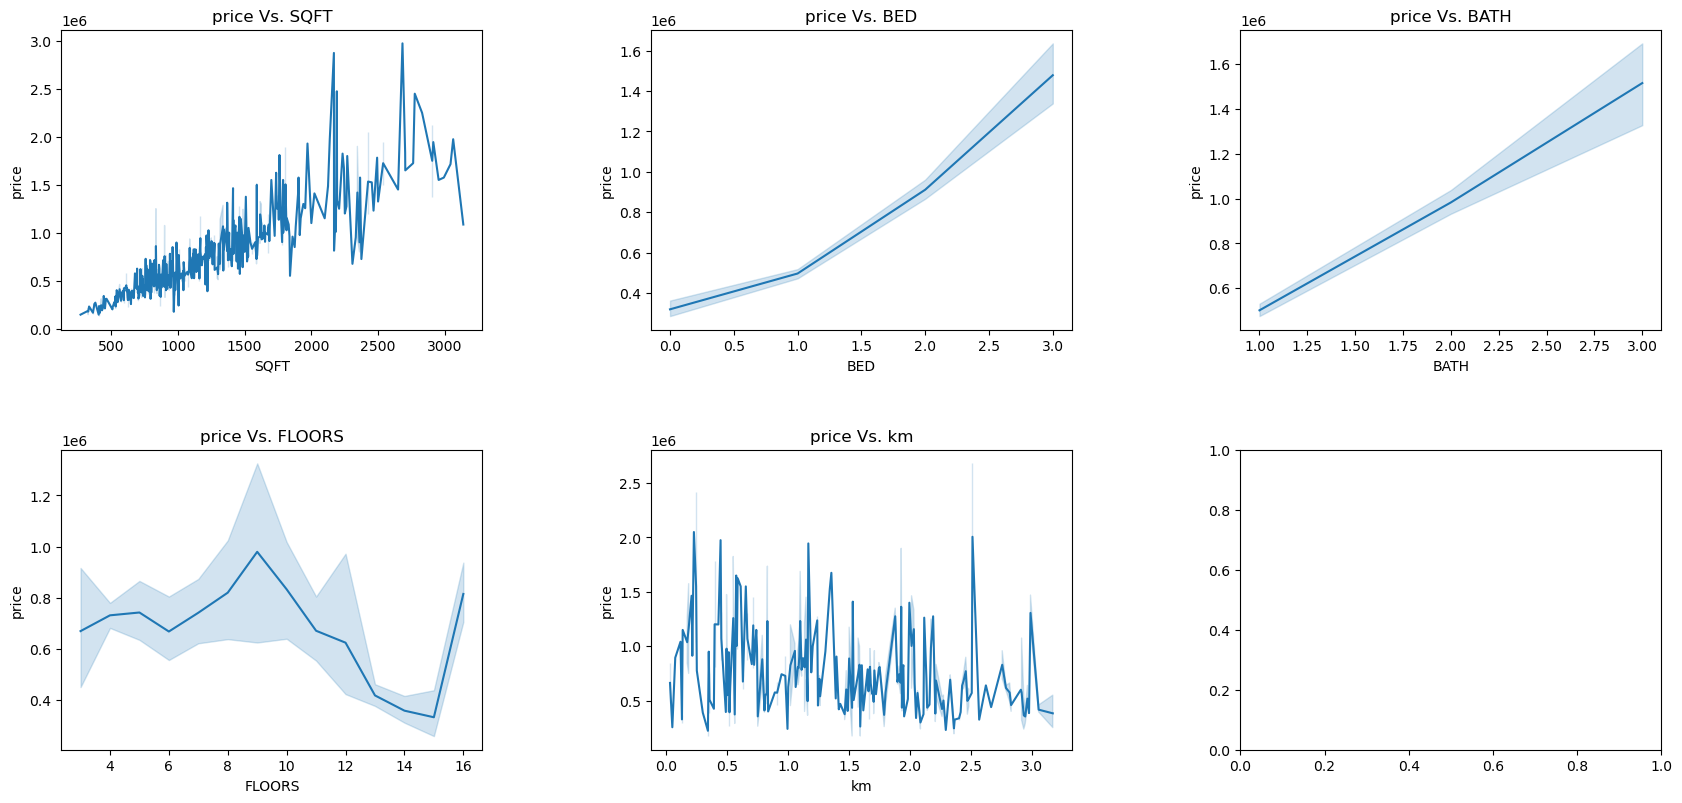

In [12]:
col_to_plot = df.columns[1::]

fig, ax = plt.subplots(2, 3, figsize = (20,9))
ax = ax.flatten()

for i, column in enumerate(col_to_plot):
    sns.lineplot(data = df, x = column, y = 'price', ax = ax[i])
    ax[i].set_title(f"price Vs. {column}")
    
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

# Univaraint Analysis

### Number of Bed Rooms

In [13]:
df['BED'].value_counts(normalize=True,dropna =False).mul(100).round(1).astype(str) + '%'

BED
1    44.4%
2    36.9%
0    10.6%
3     8.0%
Name: proportion, dtype: object

### Number of BATH Rooms

In [14]:
df['BATH'].value_counts(normalize=True,dropna =False).mul(100).round(1).astype(str) + '%'

BATH
1    62.0%
2    33.3%
3     4.7%
Name: proportion, dtype: object

### Number of FLOORS Rooms

In [15]:
df['FLOORS'].value_counts(normalize=True,dropna =False).mul(100).round(1).astype(str) + '%'

FLOORS
4     36.6%
16    12.0%
5     11.3%
6      5.4%
13     5.1%
8      5.1%
7      4.4%
3      3.5%
11     3.5%
15     3.0%
10     2.6%
9      2.6%
12     2.6%
14     2.4%
Name: proportion, dtype: object

## Histogram Visualization

C:\Users\RISHI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\RISHI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\RISHI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\RISHI\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

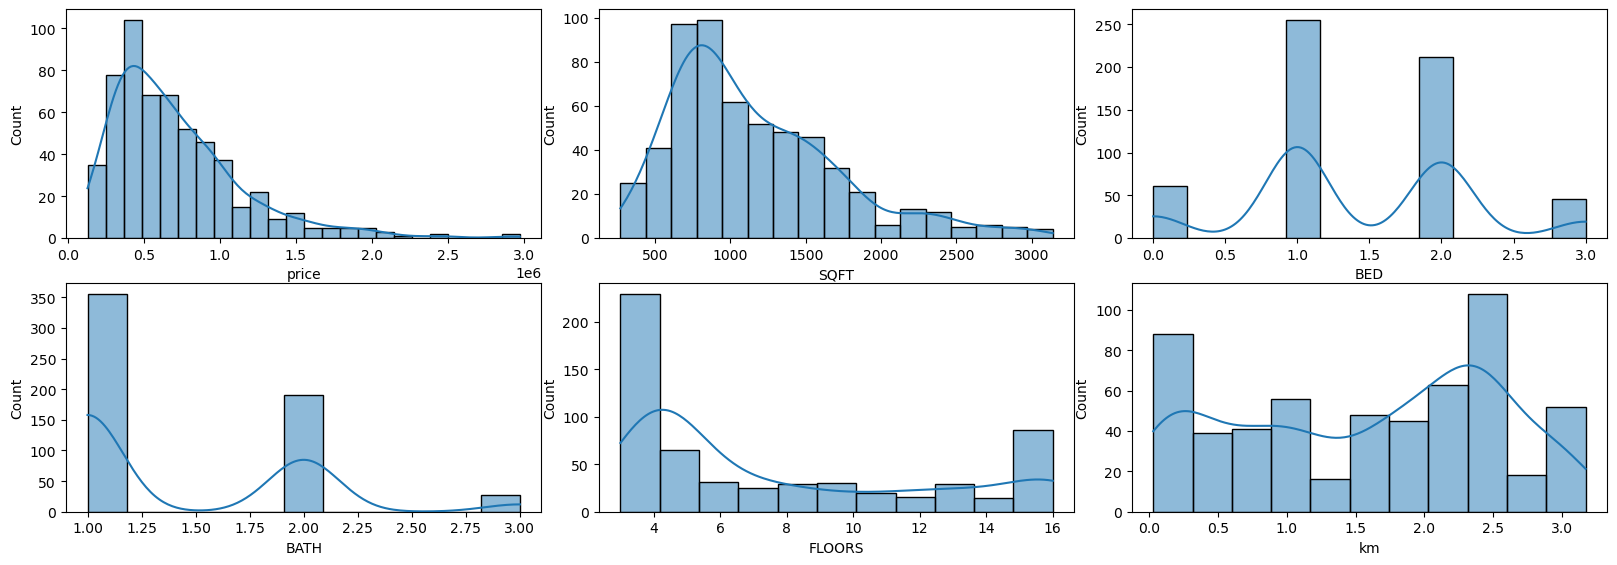

In [16]:
fig = plt.figure(figsize = (16,16))
for index, col in enumerate(df):
    plt.subplot(6,3, index +1)
    sns.histplot(df.loc[:, col], kde = True)
fig.tight_layout(pad = 0.1)

# Data Preprocessing

###  Missing Values Check

In [17]:
df.isnull().sum()

price     0
SQFT      0
BED       0
BATH      0
FLOORS    0
km        0
dtype: int64

## Handlig Outliers 

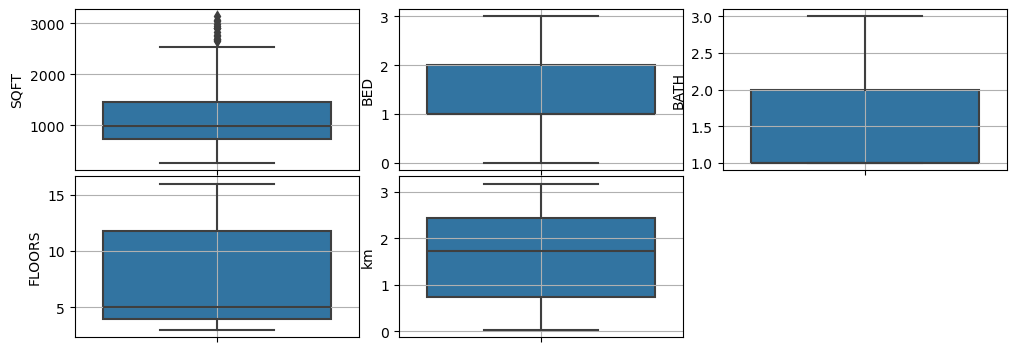

In [18]:
fig = plt.figure(figsize = (10,10))
for index, col in enumerate(df.drop(columns =['price'])):
    plt.subplot(6,3, index +1)
    sns.boxplot(y = col, data = df)
    plt.grid()
fig.tight_layout(pad = 0.1)

In [19]:
df.columns

Index(['price', 'SQFT', 'BED', 'BATH', 'FLOORS', 'km'], dtype='object')

In [20]:
for col in ['BED', 'BATH', 'FLOORS', 'km']:
    upper, lower = lower_upper(df,col)
    print(col,df[df[col]<=lower].shape[0],df[df[col]>=upper].shape[0])

BED 0 0
BATH 0 0
FLOORS 0 0
km 0 0


##### Here it is evident that, apart from SQRT column there are no ouTliers in other columns

In [21]:
## IQR method has been used for detecting outliers
upper, lower = lower_upper(df,'SQFT')

In [22]:
df[df['SQFT']<=lower].shape[0],df[df['SQFT']>=upper].shape[0],

(0, 15)

In [23]:
df[df['SQFT']>=upper]

,price,SQFT,BED,BATH,FLOORS,km
45,1835000.0,2703,3,3,16,2.012
67,1975000.0,3063,3,2,5,0.829
81,1450000.0,2650,3,3,4,0.713
108,2250000.0,2830,2,2,5,2.512
166,1550000.0,2954,2,3,16,2.439
207,2450000.0,2775,2,3,16,1.098
218,1725000.0,2763,3,2,5,0.829
229,1715000.0,3043,2,3,16,2.439
247,2125000.0,2906,3,3,5,1.146
250,1945000.0,2914,3,3,8,1.165


#### The upper limit for SQFT, calculated using the Interquartile Range (IQR) Method, is 2564.625. 
#### Upon inspection of the dataframe above, it appears that the number of bedrooms and bathrooms are more for higher SQFT
#### while the SQFT values closely align with the upper quartile range. 
#### Consequently, we can reasonably assume that there are no outliers present in the data.

## Features Correlation for multi Collinearity Check

<Axes: >

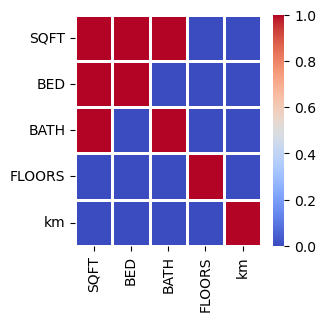

In [24]:
plt.figure(figsize =(3,3)) 
sns.heatmap((df.drop(columns = ['price'] , axis =1).corr()>=0.7) | (df.drop(columns = ['price'] , axis =1).corr()<=-0.7)\
            , cmap='coolwarm',fmt='.2f',linewidths = 1)

## SQFT has correlation with Number of Bed rooms and Bath rooms. So we need to take care for distance calculation based ML algorithms like linear regression

## Train Test Split

In [25]:
np.random.seed(20)

In [26]:
msk = np.random.rand(len(df)) <= 0.70

In [27]:
train = df[msk].reset_index(drop = True)
test = df[~msk].reset_index(drop = True)

In [28]:
train.shape[0]

391

## Standarizing the Data

In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train.drop(columns = ['price']))
X_test_scaled = scaler.transform(test.drop(columns = ['price']))

## 1.Gradient Boosting Regressor

In [30]:
model = GradientBoostingRegressor(n_estimators=50,learning_rate=0.05, max_depth=3, random_state=42)
model.fit(X_train_scaled, train['price'])
model_results(model,X_test_scaled,test,X_train_scaled, train)

,DataSet,Size,MAPE_%,R2_Score_%
0,Train,391,65.0,87.0
1,Test,183,60.0,72.0


# 2.Random Forest Regressor

In [31]:
# 5. Fit linear regression model
model = RandomForestRegressor(max_depth=4,max_features=5,n_estimators=50,random_state=20)
model.fit(X_train_scaled, train['price'])
model_results(model,X_test_scaled,test,X_train_scaled, train)

,DataSet,Size,MAPE_%,R2_Score_%
0,Train,391,69.0,87.0
1,Test,183,62.0,74.0


# 3.XGB Regressor

In [32]:
# 5. Fit linear regression model
model = xgb.XGBRegressor( n_estimators=200,gamma=0,reg_lambda=0.002,subsample=0.8, learning_rate=0.009 ,max_depth=3)
model.fit(X_train_scaled, train['price'])
model_results(model,X_test_scaled,test,X_train_scaled, train)

,DataSet,Size,MAPE_%,R2_Score_%
0,Train,391,57.0,84.0
1,Test,183,56.0,72.0


# 4.LinearRegression

In [33]:
# 5. Fit linear regression model
model = LinearRegression()
model.fit(X_train_scaled.drop(columns =['SQFT']), train['price'])
model_results(model,X_test_scaled,test,X_train_scaled, train)

AttributeError: 'numpy.ndarray' object has no attribute 'drop'

## Even keeping SQFT Varibale there is no much difference in R2_score and MAPE for testing and training dataset
## So we can include it 

## Removing SQFT to reduce multi collinearity for linear regression

In [ ]:
np.random.seed(20)
msk = np.random.rand(len(df)) <= 0.70
train = df[msk].reset_index(drop = True)
test = df[~msk].reset_index(drop = True)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train.drop(columns = ['price','SQFT']))
X_test_scaled = scaler.transform(test.drop(columns = ['price','SQFT']))

In [ ]:
model = LinearRegression()
model.fit(X_train_scaled, train['price'])
model_results(model,X_test_scaled,test,X_train_scaled, train)

In [ ]:
df.corr()

## Since the SQFT is the strong correlation with price , removing SQFT has reduced the R2_ score and MAPE 
## So we can inlcude it

# 5.Aritifical Neural Network

In [ ]:
SQFT_train = np.array(train["SQFT"])
BED_train = np.array(train["BED"])
BATH_train = np.array(train["BATH"])
FLOORS_train = np.array(train["FLOORS"])
DIST_km_train = np.array(train["km"])
price_train = np.array(train['price'])


SQFT_test = np.array(test["SQFT"])
BED_test = np.array(test["BED"])
BATH_test = np.array(test["BATH"])
FLOORS_test = np.array(test["FLOORS"])
DIST_km_test = np.array(test["km"])
price_test = np.array(test['price'])

In [ ]:
tf.random.set_seed(20)

## first layer : Input Layer

In [ ]:
sqft = tf.keras.Input(shape=(1,))    
bed = tf.keras.Input(shape=(1,))
bath = tf.keras.Input(shape=(1,))
floors = tf.keras.Input(shape=(1,))
km = tf.keras.Input(shape=(1,))

## Second layer : Normaizer

In [ ]:
## 2 nd layer
SQFT_normalizer = tf.keras.layers.experimental.preprocessing.Normalization(input_shape=[1,], axis=None)
SQFT_normalizer.adapt(SQFT_train)

BED_normalizer = tf.keras.layers.experimental.preprocessing.Normalization(input_shape=[1,], axis=None)
BED_normalizer.adapt(BED_train)

BATH_normalizer = tf.keras.layers.experimental.preprocessing.Normalization(input_shape=[1,], axis=None)
BATH_normalizer.adapt(BATH_train)

FLOORS_normalizer = tf.keras.layers.experimental.preprocessing.Normalization(input_shape=[1,], axis=None)
FLOORS_normalizer.adapt(FLOORS_train)

DIST_km_normalizer = tf.keras.layers.experimental.preprocessing.Normalization(input_shape=[1,], axis=None)
DIST_km_normalizer.adapt(DIST_km_train)

## Third layer : Weight Scaling Layer

In [ ]:
## 3rd layer
SQFTx = SQFT_normalizer(sqft)
SQFT_weight = tf.keras.layers.Dense(1, activation="relu")(SQFTx)

BEDx = BED_normalizer(bed)
BED_weight = tf.keras.layers.Dense(1, activation="relu")(BEDx)

BATHx = BATH_normalizer(bath)
BATH_weight = tf.keras.layers.Dense(1, activation="relu")(BATHx)

FLOORSx = FLOORS_normalizer(floors)
FLOORS_weight = tf.keras.layers.Dense(1, activation="relu")(FLOORSx)

DIST_kmx = DIST_km_normalizer(km)
DIST_km_weight = tf.keras.layers.Dense(1, activation="relu")(DIST_kmx)

conc1 = tf.keras.layers.Concatenate(axis=1)([SQFT_weight,BED_weight, BATH_weight,FLOORS_weight, DIST_km_weight])

In [ ]:
# 4th layyer 
logit1 = tf.keras.layers.Dense(64, activation="relu")(conc1)

# 5th layer 
l1 = tf.keras.layers.Dropout(0.25)(logit1)

# 6th layer 
logit2 = tf.keras.layers.Dense(32, activation="relu")(l1)

# 7th layer 
l2 = tf.keras.layers.Dropout(0.25)(logit2)

# 8th layer 
logit3 = tf.keras.layers.Dense(1, activation="relu")(l2)


model = tf.keras.Model(inputs=(sqft, bed, bath, floors, km), outputs=logit3, name="mmv_model")

In [ ]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    loss='mean_squared_error',  # You can also use 'mean_absolute_error' or other appropriate loss functions
    metrics=['mean_absolute_error', 'mean_squared_error'])  # You can add more metrics as needed

history = model.fit(
    [SQFT_train,BED_train,BATH_train,FLOORS_train,DIST_km_train],price_train,
    epochs=50,
    #callbacks=[get_callbacks_list(early_stopping_patience, reduce_lr_on_plateau_factor, reduce_lr_on_plateau_patience)],
    validation_data=([SQFT_test,BED_test,BATH_test,FLOORS_test,DIST_km_test],price_test))

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_loss'],label='Validation Loss'),plt.plot(history.history['loss'],label='Trian Loss')
plt.legend() 

In [ ]:
x1=train.copy()
x2=test.copy()
y_predict = model.predict([x1['SQFT'],x1['BED'],x1['BATH'],x1['FLOORS'],x1['km']])
train['predicted_price'] = y_predict

y_predict_test = model.predict([x2['SQFT'],x2['BED'],x2['BATH'],x2['FLOORS'],x2['km']])
test['predicted_price'] = y_predict_test

mape(test,train,y_predict_test,y_predict)
train_Mape,test_Mape = mape(test,train,y_predict_test,y_predict)
Train_R2_Score = metrics.explained_variance_score(train['price'], y_predict)
Test_R2_Score = metrics.explained_variance_score(test['price'], y_predict_test)

results = pd.DataFrame({'DataSet':['Train','Test'], 'Size':[train.shape[0], test.shape[0]], 'MAPE_%':[train_Mape,test_Mape],\
                 'R2_Score_%':[np.round(Train_R2_Score*100),np.round(Test_R2_Score*100)]})
results

In [ ]:
model.summary()

# Of all ML Models Random forest has higher MAPE and R2_Score